In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 16)

#FILENAME = 'images/bone247_bse_image1.tif'
FILENAME = 'images/test.jpg'
#FILENAME = 'images/bone312_bse_image6 vs annotated.jpg'
ODIR = '/home/anachronicnomad/Desktop/out_img/'
INDIR = '/home/anachronicnomad/Desktop/2020_03_05/'
FNAME = 'bone247_bse_image1 (2020_03_26 21_49_17 UTC).tif'
#FILENAME = INDIR + FNAME
OFILE = ODIR + FNAME

**Read grayscale image**

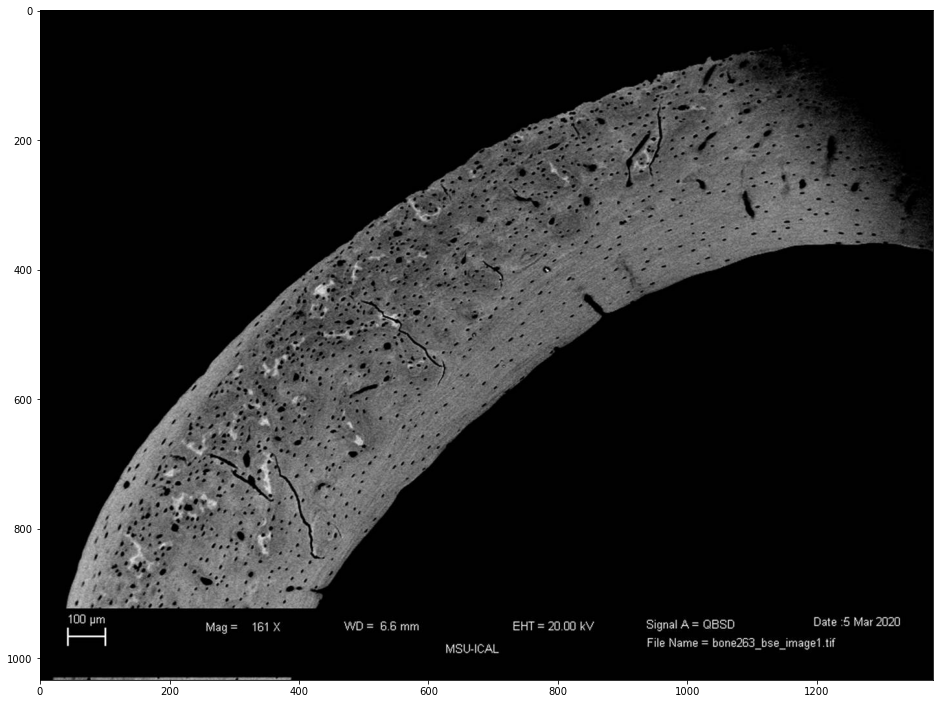

In [2]:
## Read grayscale image, 
img = cv2.imread(FILENAME, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap = 'gray')
plt.show()

**Filter To Drop Shadows, Pre-Process Bone Isolation**

* May want to use additional histogram based approaches here!

In [3]:
# Truncate all image values below threshold
ret,truncd = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)

# Take 5x5 pixel normalized average across image
blur = cv2.GaussianBlur(truncd,(5,5),0)

# Apply binary threshold, Otsu threshold
ret3,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Filter morphology - close gaps
kernel = np.ones((7,7),np.uint8)
closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

**Use Recursive convex hull to identify bone in image**

33


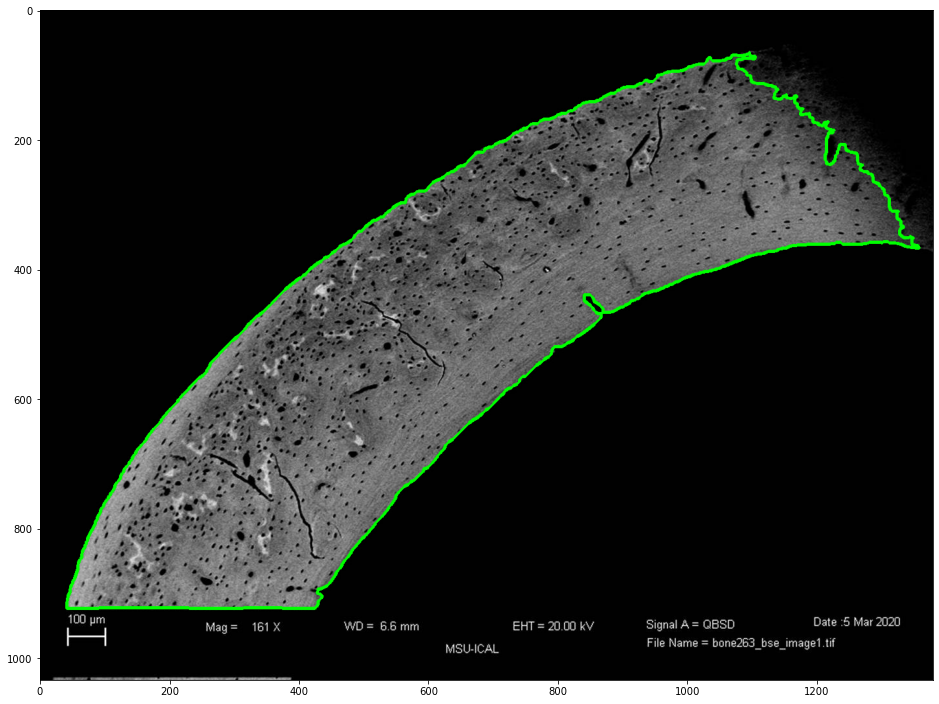

In [4]:
## Contour to find bone region
ret4 = closing.copy()
contours, hierarchy = cv2.findContours(ret4,                                       
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_TC89_L1)


                                       
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
print(max_index)

color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
tmp2 = color_img.copy() ## Save a copy, `drawContours` will mess with the image

out = cv2.drawContours(color_img, contours, max_index, (0,255,0), 3)
plt.imshow(out)
plt.show()

**Isolate bone**

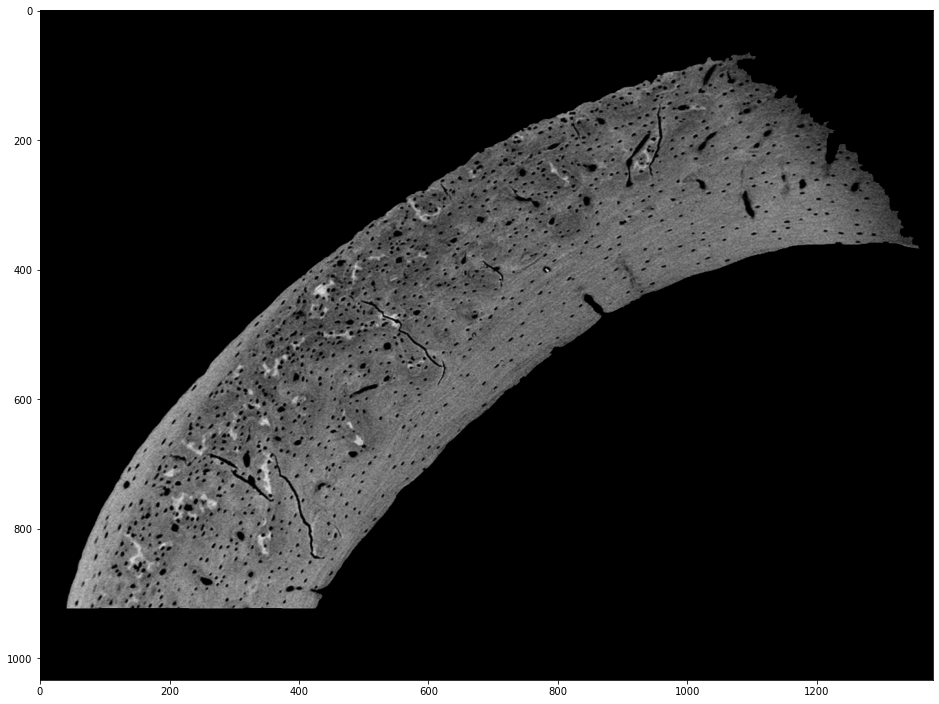

In [5]:
bone = contours[max_index]

fill_color = [0,0,0]
mask_value = 255

stencil = np.zeros(tmp2.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, [bone], mask_value)

sel = (stencil != mask_value)
tmp2[sel] = fill_color

BASE_IMG = cv2.cvtColor(tmp2, cv2.COLOR_BGR2GRAY)
plt.imshow(BASE_IMG, cmap = 'gray')
plt.show()

In [6]:
#cv2.imwrite(OFILE, BASE_IMG)

**Apply Contrast Filtering to highlight contiguous bone/adjust shadows**

Here, we use Contrast-Limited Adaptive Histogram Equalization (CLAHE).  We want tiled grids of roughly 16x16 pixels, so we have to define the number of rows and columns by the ceiling of the width and height of the image over 8. 

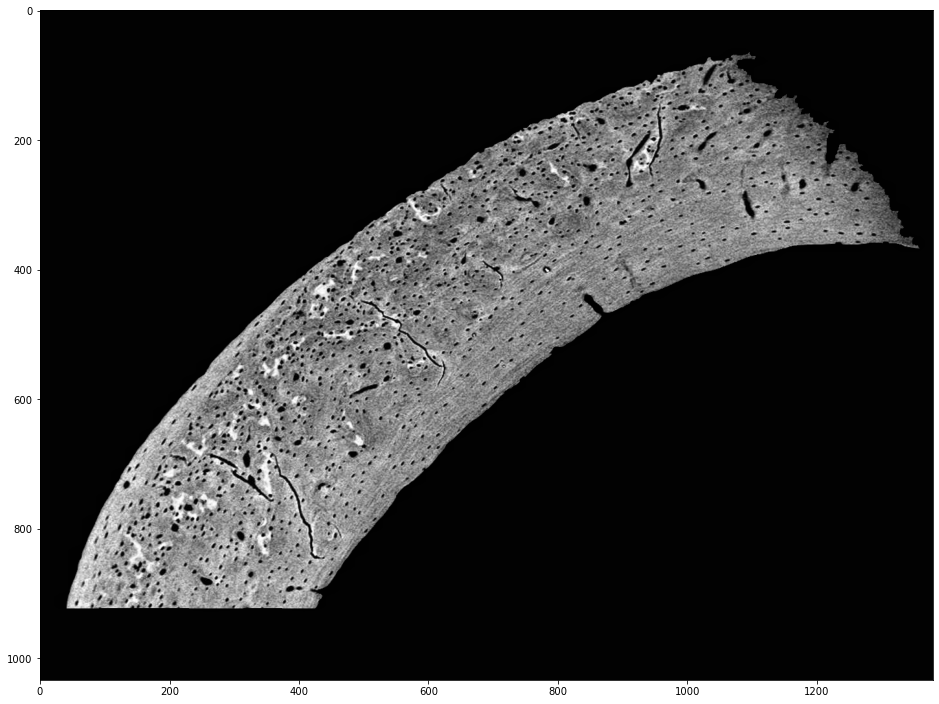

In [7]:
PIX = 16
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(int(np.ceil(BASE_IMG.shape[0] / PIX)),
                                                        int(np.ceil(BASE_IMG.shape[1] / PIX))))
equalized = clahe.apply(BASE_IMG)

plt.imshow(equalized, cmap = 'gray')
plt.show()

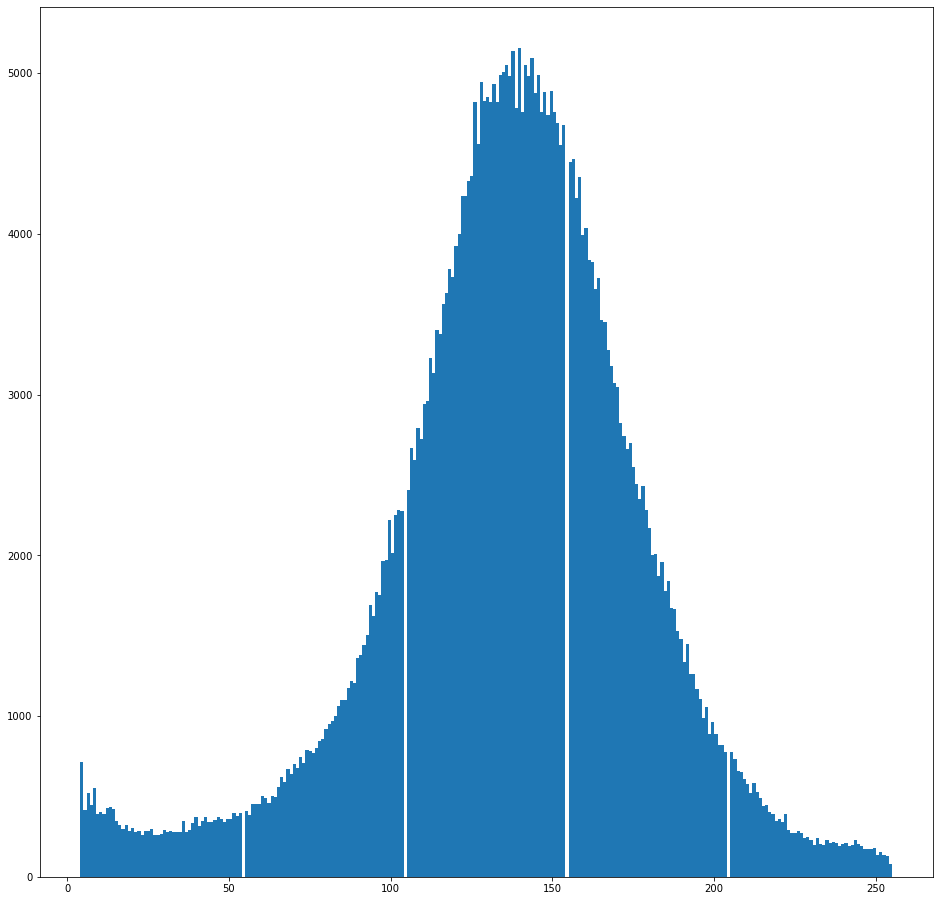

In [8]:
tmp3 = equalized.copy()
tmp3 = tmp3[np.where(tmp3 >= 4)].ravel()
plt.hist(tmp3, bins=256)
plt.show()

**Apply Color Quantization**

We will use 7 colors to represent five categories of mineralized bone or lack thereof we may find in an image.  

We must assume that these five categories will exist in any 

1. Pitch Black `0` - no bone in this pixel
2. Osteocyte (small black circle in bone)
3. Shadow?
4. Very high mineralization content -- observed visual "chunks" in non-lamellar bone. 
5. Moderate mineralization content -- observed visual lines in lamellar bone.
6. Moderate lack of mineralization content -- observed visual lines in lamellar bone. 
7. Mineralization deprived, relative to (4) -- observed visual chunks in non-lamellar bone. 

We proceed to take the array of grayscale values in the image, and categorize all pixels of the image using $k$-means clustering.  This is done using 10-fold cross-validation and initially random pixels representing grayscale values for each of the 5 categories (centers).

In [9]:
img = equalized.copy()
Z = img.reshape((-1,2))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            4096, 1E-5)
K = 7
ret,label,center=cv2.kmeans(Z,K,None,criteria,20,
                            cv2.KMEANS_RANDOM_CENTERS)

# New Stuff A

Now let's take the clusters identified and reform it into an image with consistent grayscale values.  In the printout below this cell, you can observe a listing of the lower and upper estimates for the grayscale value associated with a cluster, followed by an image colored in with the adjusted (consistent) values. 

[[213.68431   213.71371  ]
 [  3.120553    3.1224475]
 [101.67863   101.45949  ]
 [127.86271   127.7469   ]
 [ 59.318096   60.160965 ]
 [175.93446   176.05067  ]
 [150.60733   150.57997  ]]


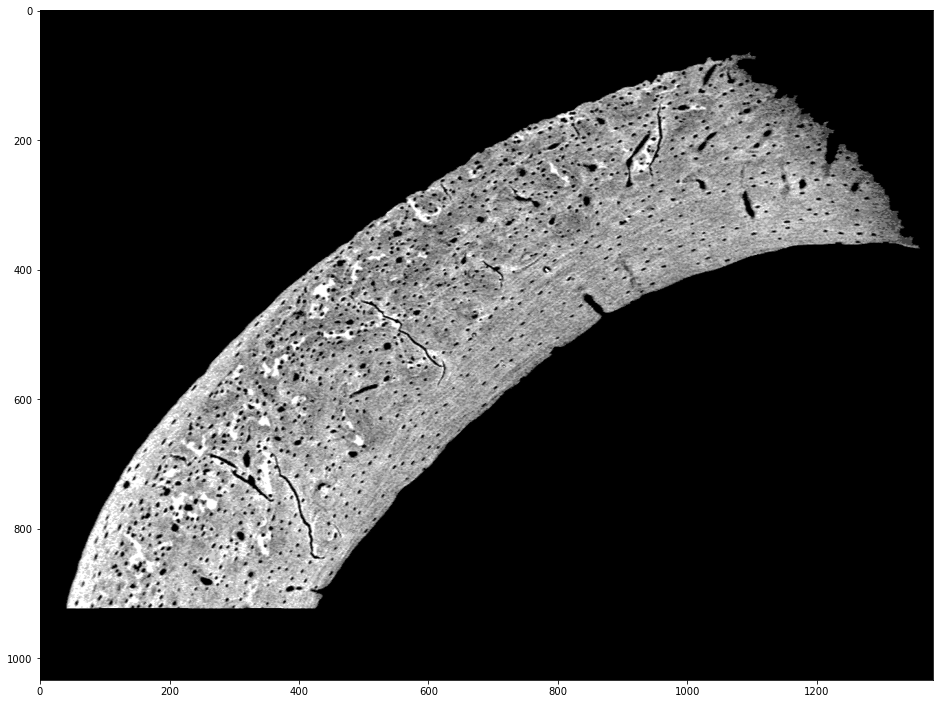

In [10]:
# These are the estimates for the centroids; 
# the estimate for the grayscale value for that cluster
print(center)

# We want to floor & reassign the midpoints of the estimates
# to be the centroids proper.  This avoids rounding issues
# when using the lower/upper estimates
for i in range(0,len(center)):
    a = center[i]
    b = (a[0] + a[1]) / 2
    center[i] = np.array([b, b])

# Now convert back into uint8, and make original image
# This is done for demonstration/viz purposes, we will not 
# be able to directly use these values
center_conv = np.uint8(center)
res = center_conv[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2, cmap = 'gray')
plt.show()

# New Stuff B

**However, what makes more sense now, is that we know clusters near the "middle" of the histogram have an "average" mineralization content -- and therefore may be lamellar.  This means that given 7 clusters, minus the "black"/"empty" bucket (for a total of 6 clusters), the middle buckets may be lamellar and the futher from the mean, the outer buckets are probably non-lamellar**

Here are the grayscale values sorted, in order. 

In [13]:
tmp1 = res2.copy()
category_grayscale_values = np.sort(np.unique(tmp1.flatten()))
category_grayscale_values

array([  3,  59, 101, 127, 150, 175, 213], dtype=uint8)

To illustrate what's happened, let's start "removing" certain classification of mineral density from the image. In this case, the middle buckets have been blanked out. 

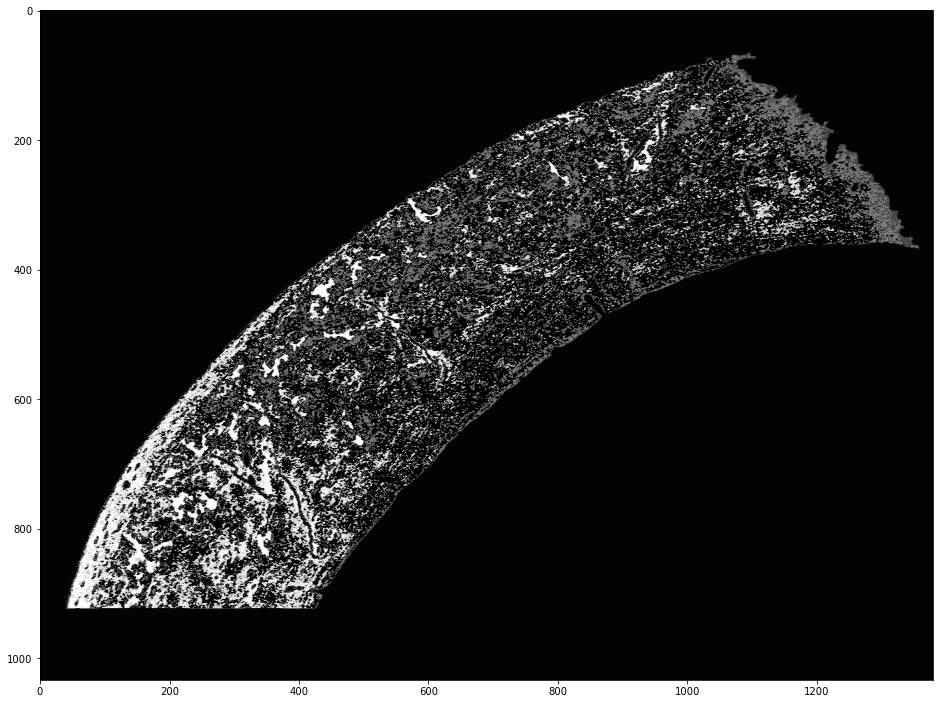

In [16]:
tmp1 = res2.copy()

#lam_lo = np.max(category_grayscale_values)
lam_hi = category_grayscale_values[3]
lam_nx = category_grayscale_values[4]

#tmp1[np.where(tmp1 == lam_lo)] = [0]
tmp1[np.where(tmp1 == lam_hi)] = [0]
tmp1[np.where(tmp1 == lam_nx)] = [0]

plt.imshow(tmp1, cmap = 'gray')
plt.show()

Here, instead, I keep everything in the middle buckets. 

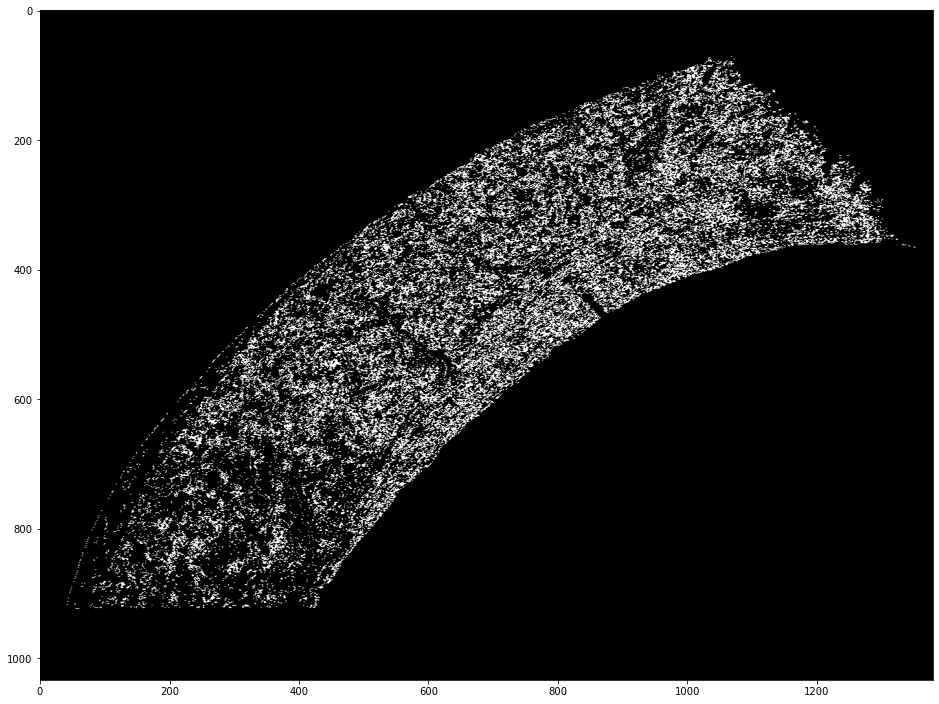

In [24]:
tmp1 = res2.copy()

tmp1[np.where(tmp1 == category_grayscale_values[0])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[1])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[2])] = [0]
#tmp1[np.where(tmp1 == category_grayscale_values[3])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[4])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[5])] = [0]
tmp1[np.where(tmp1 == category_grayscale_values[6])] = [0]

plt.imshow(tmp1, cmap = 'gray')
plt.show()